# predict NBA 🏆 by SVM

## 1 package import

In [68]:
# env
import sys
print(sys.version)
!pip list

3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
Package              Version
-------------------- -----------
anyio                3.6.2
argon2-cffi          21.3.0
argon2-cffi-bindings 21.2.0
attrs                22.1.0
backcall             0.2.0
beautifulsoup4       4.11.1
bleach               5.0.1
certifi              2022.9.24
cffi                 1.15.1
click                8.1.3
colorama             0.4.6
colorlog             6.7.0
cycler               0.11.0
debugpy              1.6.3
decorator            5.1.1
defusedxml           0.7.1
easydev              0.12.0
entrypoints          0.4
fastjsonschema       2.16.2
fitter               1.3.0
fonttools            4.38.0
idna                 3.4
importlib-metadata   5.0.0
importlib-resources  5.10.0
ipykernel            6.16.2
ipython              7.34.0
ipython-genutils     0.2.0
ipywidgets           8.0.2
jedi                 0.18.1
Jinja2               3.1.2
joblib               1.2.0
jsonschema           

In [69]:
import numpy as np
import pandas as pd

# for classification
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.pipeline import make_pipeline

# for Generator
from scipy import stats
from fitter import Fitter
import copy

# for visualization 
import matplotlib.pyplot as plt
# for coloring 
import seaborn as sns
# set style of graphs
plt.style.use('classic')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

## 2 Data cleaning and preprocessing

We would like to sort the dataset in chronological order, remove the NaN values, and pre-process the data to distinguish between hosts and visitors.

In [70]:
# load data
df = pd.read_csv("./data/games.csv")
df.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-03-12,22101005,Final,1610612748,1610612750,2021,1610612748,104.0,0.398,0.760,...,23.0,53.0,1610612750,113.0,0.422,0.875,0.357,21.0,46.0,0
1,2022-03-12,22101006,Final,1610612741,1610612739,2021,1610612741,101.0,0.443,0.933,...,20.0,46.0,1610612739,91.0,0.419,0.824,0.208,19.0,40.0,1
2,2022-03-12,22101007,Final,1610612759,1610612754,2021,1610612759,108.0,0.412,0.813,...,28.0,52.0,1610612754,119.0,0.489,1.000,0.389,23.0,47.0,0
3,2022-03-12,22101008,Final,1610612744,1610612749,2021,1610612744,122.0,0.484,0.933,...,33.0,55.0,1610612749,109.0,0.413,0.696,0.386,27.0,39.0,1
4,2022-03-12,22101009,Final,1610612743,1610612761,2021,1610612743,115.0,0.551,0.750,...,32.0,39.0,1610612761,127.0,0.471,0.760,0.387,28.0,50.0,0


In [71]:
# # sort data by GAME_DATA_EST
df = df.sort_values(by='GAME_DATE_EST').reset_index(drop = True)
# drop NaN data and check
df = df.loc[df['GAME_DATE_EST'] >= "2004-01-01"].reset_index(drop=True)
df.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2004-01-02,20300458,Final,1610612750,1610612737,2003,1610612750,93.0,0.409,0.929,...,32.0,56.0,1610612737,75.0,0.372,0.737,0.375,22.0,31.0,1
1,2004-01-02,20300451,Final,1610612764,1610612744,2003,1610612764,97.0,0.446,0.611,...,30.0,58.0,1610612744,79.0,0.403,0.818,0.381,20.0,36.0,1
2,2004-01-02,20300454,Final,1610612752,1610612741,2003,1610612752,99.0,0.470,0.800,...,25.0,38.0,1610612741,104.0,0.488,0.724,0.385,20.0,44.0,0
3,2004-01-02,20300457,Final,1610612765,1610612756,2003,1610612765,93.0,0.389,0.947,...,26.0,54.0,1610612756,81.0,0.395,0.895,0.364,20.0,34.0,1
4,2004-01-02,20300456,Final,1610612748,1610612753,2003,1610612748,112.0,0.466,0.792,...,29.0,42.0,1610612753,101.0,0.430,0.750,0.450,15.0,37.0,1


In [72]:
# replace Team ID with Names
df_names = pd.read_csv('./data/teams.csv')
df_names.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,1610612737,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,1610612738,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,1610612740,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,1610612741,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,1610612742,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


In [73]:
# replace 'HOME_TEAM_ID' and 'VISITOR_TEAM_ID' with names in df_names
df_names = df_names[['TEAM_ID', 'NICKNAME']]
# replace 'HOME_TEAM_ID'
home_names = df_names.copy()
home_names.columns = ['HOME_TEAM_ID', 'NICKNAME']
result_1 = pd.merge(df['HOME_TEAM_ID'], home_names, how ="left", on="HOME_TEAM_ID")  
df['HOME_TEAM_ID'] = result_1['NICKNAME']
# replace 'VISITOR_TEAM_ID'
visitor_names = df_names.copy()
visitor_names.columns = ['VISITOR_TEAM_ID', 'NICKNAME']
result_2 = pd.merge(df['VISITOR_TEAM_ID'], visitor_names, how = "left", on="VISITOR_TEAM_ID")
df['VISITOR_TEAM_ID'] = result_2['NICKNAME']
print(df)

      GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID VISITOR_TEAM_ID  \
0        2004-01-02  20300458            Final  Timberwolves           Hawks   
1        2004-01-02  20300451            Final       Wizards        Warriors   
2        2004-01-02  20300454            Final        Knicks           Bulls   
3        2004-01-02  20300457            Final       Pistons            Suns   
4        2004-01-02  20300456            Final          Heat           Magic   
...             ...       ...              ...           ...             ...   
25227    2022-03-12  22101010            Final          Jazz           Kings   
25228    2022-03-12  22101009            Final       Nuggets         Raptors   
25229    2022-03-12  22101008            Final      Warriors           Bucks   
25230    2022-03-12  22101006            Final         Bulls       Cavaliers   
25231    2022-03-12  22101005            Final          Heat    Timberwolves   

       SEASON  TEAM_ID_home  PTS_home  

## 3 Segmentation of Data Set

We want to try and predict the 2020-2021 NBA play off results starting 2021-08 hence, this portion of the data is the test data set and others are the train data set.

In [74]:
df = df.loc[df['GAME_DATE_EST'] < '2021-08-01'].reset_index(drop=True)

## 4 Features selection

There are two ways to select the features.
1. Select only one feature (points), the prediction is just based on which team has the higher point.
2. Select features other than points, the resoult is based on the prediction of a classifier which takes those features as inputs.

Now we choose the ***second selection***.

In [75]:
# list all features
feature_list = list(df.columns)
feature_list

['GAME_DATE_EST',
 'GAME_ID',
 'GAME_STATUS_TEXT',
 'HOME_TEAM_ID',
 'VISITOR_TEAM_ID',
 'SEASON',
 'TEAM_ID_home',
 'PTS_home',
 'FG_PCT_home',
 'FT_PCT_home',
 'FG3_PCT_home',
 'AST_home',
 'REB_home',
 'TEAM_ID_away',
 'PTS_away',
 'FG_PCT_away',
 'FT_PCT_away',
 'FG3_PCT_away',
 'AST_away',
 'REB_away',
 'HOME_TEAM_WINS']

In [76]:
# selecte features
selected_features = [
    'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home',
    'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away',
    ]
X = df[selected_features]
X.head()

,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away
0,0.409,0.929,0.308,32.0,56.0,0.372,0.737,0.375,22.0,31.0
1,0.446,0.611,0.400,30.0,58.0,0.403,0.818,0.381,20.0,36.0
2,0.470,0.800,0.333,25.0,38.0,0.488,0.724,0.385,20.0,44.0
3,0.389,0.947,0.238,26.0,54.0,0.395,0.895,0.364,20.0,34.0
4,0.466,0.792,0.500,29.0,42.0,0.430,0.750,0.450,15.0,37.0


In [77]:
# check the targets
y = df['HOME_TEAM_WINS']
y.head()

0    1
1    1
2    0
3    1
4    1
Name: HOME_TEAM_WINS, dtype: int64

In [78]:
# turn data into numpy arrays for training
X = X.to_numpy()
y = y.to_numpy()

## 5 Fitting SVM

In [79]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.3, random_state = 42)

print("X shape", X_train.shape, "y shape", y_train.shape)

X shape (16909, 10) y shape (16909,)


In [80]:
# feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [81]:
# train SVM
clf = svm.SVC(kernel='linear') # initialize a model
clf.fit(X_train, y_train) # fit(train) it with the training data and targets

# check test score 
y_pred = clf.predict(X_test) 
print('balanced accuracy score:', balanced_accuracy_score(y_test, y_pred)) 

balanced accuracy score: 0.6959311555145645


In [82]:
# fine-tuning hyperparameters
scoring = make_scorer(balanced_accuracy_score)
param_grid = {'C': [0.1, 1, 10],  
              'gamma': [1,0.1,0.01]}

grid = GridSearchCV(svm.SVC(kernel='linear'), param_grid, scoring = scoring, refit=True, verbose=2) 
grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .....................................C=0.1, gamma=1; total time=   1.5s
[CV] END .....................................C=0.1, gamma=1; total time=   1.5s
[CV] END .....................................C=0.1, gamma=1; total time=   1.5s
[CV] END .....................................C=0.1, gamma=1; total time=   1.4s
[CV] END .....................................C=0.1, gamma=1; total time=   1.4s
[CV] END ...................................C=0.1, gamma=0.1; total time=   1.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=   1.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=   1.4s
[CV] END ...................................C=0.1, gamma=0.1; total time=   1.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=   1.4s
[CV] END ..................................C=0.1, gamma=0.01; total time=   1.4s
[CV] END ..................................C=0.1,

GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]},
             scoring=make_scorer(balanced_accuracy_score), verbose=2)

In [83]:
# print the best model's hyperparameters
Dis = grid.best_estimator_
print(Dis)

SVC(C=0.1, gamma=1, kernel='linear')


## 6 Fitting a Generator

Since we aim to predict 2020-2021 playoff, here we will just fit the data from that regular session which starts in Oct, 2020.   
For time-series problems, we give priority to the recent data most reflective of team's recent ability.

In [84]:
df_ = df.loc[df['GAME_DATE_EST'] > '2020-10-01'].reset_index(drop=True)
df_.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2020-10-02,41900402,Final,Lakers,Heat,2019,1610612747,124.0,0.505,0.588,...,32.0,44.0,1610612748,114.0,0.507,0.912,0.407,29.0,37.0,1
1,2020-10-04,41900403,Final,Heat,Lakers,2019,1610612748,115.0,0.513,0.913,...,25.0,37.0,1610612747,104.0,0.430,0.759,0.333,23.0,43.0,1
2,2020-10-06,41900404,Final,Heat,Lakers,2019,1610612748,96.0,0.427,0.808,...,18.0,39.0,1610612747,102.0,0.443,0.857,0.359,25.0,42.0,0
3,2020-10-09,41900405,Final,Lakers,Heat,2019,1610612747,108.0,0.463,0.857,...,21.0,41.0,1610612748,111.0,0.458,0.955,0.424,26.0,35.0,0
4,2020-10-11,41900406,Final,Heat,Lakers,2019,1610612748,93.0,0.443,0.591,...,25.0,41.0,1610612747,106.0,0.483,0.643,0.314,23.0,46.0,0


In [85]:
# define the list of common distributions for fitting
selected_distributions = [
    'norm','t', 'f', 'chi', 'cosine', 'alpha', 
    'beta', 'gamma', 'dgamma', 'dweibull',
    'maxwell', 'pareto', 'fisk']

# extract all the unique teams
unique_teams = df['HOME_TEAM_ID'].unique()

# Get all the data for teams
all_team_sim_data = {}

for team_name in unique_teams:
    
    # find games where the team is either the host or guest
    df_team = df_.loc[(df_['HOME_TEAM_ID'] == team_name) | (df_['VISITOR_TEAM_ID'] == team_name)]
    df_1 = df_team.loc[df_team['HOME_TEAM_ID'] == team_name][selected_features[:5]]
    df_0 = df_team.loc[df_team['VISITOR_TEAM_ID'] == team_name][selected_features[5:]]

    # combine df_0 and df_1
    df_0.columns = df_1.columns
    df_s = pd.concat([df_1, df_0], axis = 0)
    
    # convert the pandas.DataFrame to numpy array
    all_team_sim_data[team_name] = df_s.to_numpy()

In [86]:
megadata = {} # store the data that our Generator will rely on

for team_name in unique_teams:
    
    feature_dis_paras = []
    data = all_team_sim_data[team_name]
    
    # 5 features for each team
    for i in range(5): 
        f = Fitter(data[:, i])
        f.distributions = selected_distributions
        f.fit()
        best_paras = f.get_best(method='sumsquare_error')
        feature_dis_paras.append(best_paras)
        
    megadata[team_name] = feature_dis_paras
    
print('Features for all teams have been fitted!')

Features for all teams have been fitted!


## 7 Simulation

In [87]:
DATA = megadata.copy() # data that Generator must rely on

GEN = {
 'alpha': stats.alpha.rvs,
 'beta': stats.beta.rvs,
 'chi': stats.chi.rvs,
 'cosine': stats.cosine.rvs,
 'dgamma': stats.dgamma.rvs,
 'dweibull':stats.dweibull.rvs,
 'f':stats.f.rvs,
 'fisk':stats.fisk.rvs,
 'gamma': stats.gamma.rvs,
 'maxwell':stats.maxwell.rvs,
 'norm':stats.norm.rvs,
 'pareto':stats.pareto.rvs,
 't':stats.t.rvs,
}

# feature scaler + fine-turned SVM 
DIS = make_pipeline(scaler, Dis)

In [88]:
class Game:
    
    '''
    
    A game between two teams:
    
    - feature values sampled from Generator
    - win/loss predicted by Discriminator
    
    '''
    
    def __init__ (self, random_state = None):
        
        self.random_state = random_state # keep this to None for making simulations 
    
    def predict(self, team1, team2, num_games = 1):
        
        ''' predict the win or loss of  n game(s) played by two tems'''
        
        assert num_games >= 1, "at least one game must be played"
        # output numpy array
        team_1_feature_data = DATA[team1]
        team_2_feature_data = DATA[team2]
        features = []
        for feature_paras_1 in team_1_feature_data:
            sample_1 = self.sampling(feature_paras_1, size = num_games) # gives a list if num_games> 1
            features.append(sample_1) 
            
        for feature_paras_2 in team_2_feature_data:
            sample_2 = self.sampling(feature_paras_2, size = num_games) # gives a list if num_games> 1
            features.append(sample_2)
            
        features = np.array(features).T 
        win_loss = DIS.predict(features)
        
        return list(win_loss) # a list of win/loss from num_games
    
    
    def sampling(self, dic, size = 1, random_state = None):
        
        '''generate feature values used for making win/loss prediction'''
                        
        dis_name = list(dic.keys())[0] # get the type
        paras = list(dic.values())[0] # get the paras
    
        # get sample
        sample = GEN[dis_name](*paras, size = size,  random_state =  random_state)
            
        return sample 

In [89]:
class FinalTournament(Game):
    
    ''' Best-of-7 elimination, 16 teams, 4 rounds in total to win championship '''
    
    def __init__(self, n_games_per_group = 7, winning_threshold = 4, random_state = None):

        self.n_games_per_group  = n_games_per_group
        self.winning_threshold = winning_threshold
        self.team_list = None
        self.rounds = {} # keep track the number of times a team wins at each round 
        super().__init__(random_state)
        
    
    def simulate(self, group_list, n_simulation = 1, probs = True):
        
        ''' simulate the entire playoff n times and also record the accumulated wins'''
             
        # update the list of teams
        self.rounds = {}
        self.team_list = [i[0] for i in group_list] + [i[1] for i in group_list]
        
        for i in range(n_simulation):
            cham = self.one_time_simu(group_list)
        if probs:
            self.rounds_probs =  self._compute_probs()
            
    
    def one_time_simu(self, group_list, verbose = False, probs = False):
        
        ''' simulate the entire playoff once and also record the accumulated wins'''
        
        # update the list of teams if haven't done so
        if self.team_list == None: 
            self.team_list = [i[0] for i in group_list] + [i[1] for i in group_list]
        round_number, done = 0, 0
        while not done: 
            all_group_winners, group_list = self.play_round(group_list)
            # retrive round stats
            try:
                updated_round_stats = self.rounds[round_number]
            except KeyError:
                updated_round_stats = {}
                for team in self.team_list:
                    updated_round_stats[team] = 0
            # if a team wins, record + 1 
            for winner in all_group_winners:
                try: 
                    updated_round_stats[winner] += 1
                except KeyError:
                    pass     
            self.rounds[round_number] = updated_round_stats
            if verbose:
                print('{} round played'.format(round_number))
            if probs:
                self.rounds_probs = self._compute_probs()
            if type(group_list) != list: # if it becomes the final
                done = 1
            round_number += 1
            
        return group_list

        
    def play_round(self, group_list):
        
        '''play a round of games based of a list of paired teams'''
        
        all_group_winners = [] 
        # play each group and get the group winner
        for group in group_list:
            winner = self.play_n_games(group[0], group[1])
            all_group_winners.append(winner)
        
        if len(all_group_winners) > 1:
            new_group_list = []         
            for index in range(0, len(all_group_winners), 2):
                # first winner, second winner
                new_group = [all_group_winners[index], all_group_winners[index + 1]]
                new_group_list.append(new_group)
                
            return all_group_winners, new_group_list
        else:  
            return all_group_winners, winner
        
        
    def play_n_games(self, team1, team2):
        
        '''simulate data, and then use our classifier to predict win/loss'''
        
        result = Game().predict(team1, team2, self.n_games_per_group)
        if sum(result[:4]) == self.winning_threshold or sum(result) >= self.winning_threshold:
            winner = team1 # home team wins
        else:
            winner = team2 # visitor team wins
            
        return winner
    
    
    def _compute_probs(self):
        
        '''prob = wins for a team / sum of wins for all teams at a particular round'''
        
        rounds_probs = copy.deepcopy(self.rounds)
        for round_number, round_stats in rounds_probs.items():
            m = np.sum(list(round_stats.values()))
            for k, v in rounds_probs[round_number].items():
                rounds_probs[round_number][k] = v / m
                
        return rounds_probs

In [90]:
# the below roster is based on 2020-2021 NBA playoffs
# https://en.wikipedia.org/wiki/2020%E2%80%9321_NBA_season

group_list = [
     # Eastern Conference
     ('76ers', 'Wizards'),          # group A 
     ('Knicks', 'Hawks'),           # group B
    
     ('Bucks', 'Heat'),             # group C
     ('Nets', 'Celtics'),           # group D
    
     # Western Conference
     ('Jazz', 'Grizzlies'),         # group E
     ('Clippers', 'Mavericks'),     # group F
    
     ('Nuggets', 'Trail Blazers'),  # group G
     ('Suns', 'Lakers')]            # group H

In [91]:
# initiate a playoff
playoff = FinalTournament()
# simulate the playoff 5,000 times
playoff.simulate(group_list, n_simulation = 5000)

In [92]:
# see the winning probabilities from 5,000 playoffs
round_df = pd.DataFrame(playoff.rounds_probs)
round_df

,0,1,2,3
76ers,0.078125,0.10700,0.0976,0.1030
Knicks,0.054300,0.02460,0.0137,0.0076
Bucks,0.099875,0.09435,0.0949,0.1040
Nets,0.111825,0.13580,0.1808,0.2530
Jazz,0.087000,0.10075,0.0873,0.0568
Clippers,0.102825,0.10290,0.1116,0.0944
Nuggets,0.115875,0.15185,0.1706,0.1726
Suns,0.116300,0.09140,0.0956,0.0902
Wizards,0.046875,0.06025,0.0521,0.0482
Hawks,0.070700,0.05815,0.0493,0.0464


## 8 Visualization

In [93]:
def plotting(rounds_data):
    
    rounds_stats = list(rounds_data.values())
    team_names = list(rounds_stats[0].keys())
    
    # x is number of rounds used for labels, y is a 2-D array of (n_teams, n_rounds) used for data
    x = list(rounds_data.keys())
    y = np.array([list(r.values()) for r in rounds_stats]).T 
    
    # we need at least 16 different colors, one for each team
    c_1 =  sns.color_palette('tab10', n_colors = 10)
    c_2 =  sns.color_palette("pastel", n_colors = 10)
    color_map = c_1 + c_2 
    
    fig = plt.figure()
    plt.stackplot(x, y, labels = team_names, colors = color_map) 
    plt.legend(bbox_to_anchor=(1.1, 1.1), loc = 'upper left', fontsize=13)
    plt.xticks(x, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Round Number', fontsize = 15)
    plt.title('Winning probabilities by all Teams & Rounds', pad = 20, fontsize = 24)
    plt.tight_layout()
    plt.show()
    
    return fig

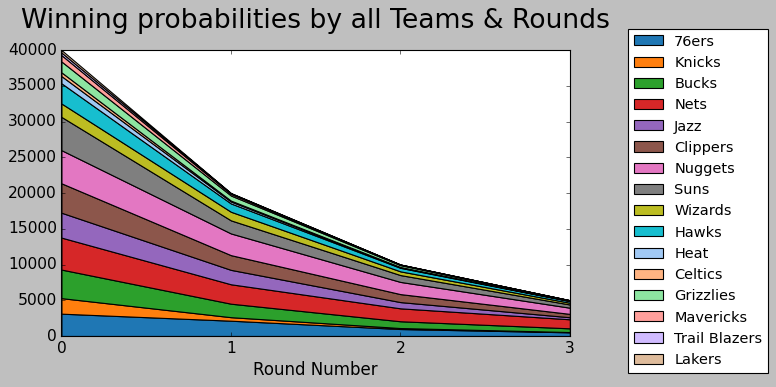

In [94]:
# check that a team's wins should get less and less in later rounds
fig = plotting(playoff.rounds)

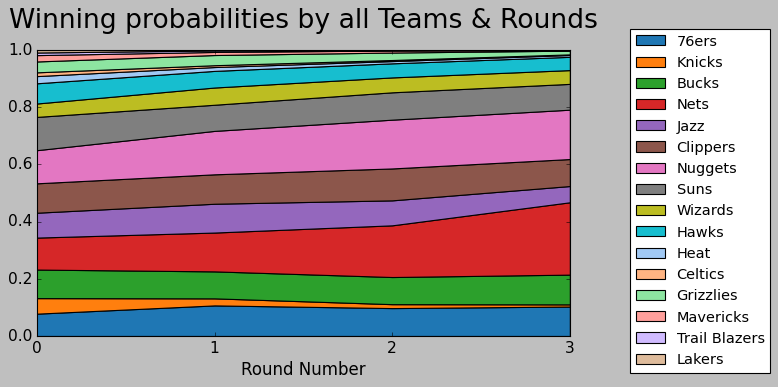

In [95]:
# plot the results: probabilities of winning for all teams at each round
fig = plotting(playoff.rounds_probs)

In [96]:
# over all rounds winning probabilities
overall_rounds_df = round_df
overall_rounds_df[4] = (round_df[0] + round_df[1] + round_df[2] + round_df[3])/4
overall_rounds_res = overall_rounds_df.sort_values(by=4,ascending=False)
print('Over all rounds winning probabilities:')
print(overall_rounds_res[4].head(5))

# the final round winning probabilities
final_round_res = round_df.sort_values(by=3,ascending=False)
print('The final round winning probabilities:')
print(final_round_res[3].head(5))

Over all rounds winning probabilities:
Nets        0.170356
Nuggets     0.152731
Clippers    0.102931
Suns        0.098375
Bucks       0.098281
Name: 4, dtype: float64
The final round winning probabilities:
Nets        0.2530
Nuggets     0.1726
Bucks       0.1040
76ers       0.1030
Clippers    0.0944
Name: 3, dtype: float64


## 9 Result

| type | winner |  
| :-: | :-:|
| 模型预测结果 | Nets > Nuggets > Bucks |  
| 实际结果 | Bucks |